# Datacenter Emissions

## Overview



This notebook explains how to leverage the **location and market API** services for calculating Scope 2 emissions in data centers. These APIs provide the necessary emission factors to automate the process of calculating greenhouse gas emissions associated with electricity, steam, heat, and cooling workloads.

By understanding these emissions, datacenter operators can assess their environmental impact for reporting and identify opportunities for emissions reduction.



![datacenter_emission_capture.png](datacenter_emission_capture.png)

### Setup

Make sure you have Python installed in your system (python 3+ is required).


<b>Note:</b> To run this notebook seamlessly, you have to first configure your GHG Emission APIs' credentials in a file named `secrets.ini` in the below format:

```
[EI]
api.api_key = <Your GHG APIs API key>
api.client_id = <Your GHG APIs client Id>

```

Keep the secrets.ini file at an appropriate relative location of this notebook. For example, as specified in the below config.

```config.read('../../auth/secrets.ini')```

In [2]:
# Install the packages below using pip/pip3 based on your python version.
#!pip install pandas configparser IPython plotly datetime kaleido
import pandas as pd
import configparser
import requests
import json
from IPython.display import display as display_summary
import plotly.express as px
from plotly.offline import init_notebook_mode
from plotly.offline import iplot
from datetime import datetime
import plotly.graph_objects as go

### Get token


Run the below code snippet to generate the Auth Bearer Token using your api_key configured in secrets.ini.

In [3]:
config = configparser.RawConfigParser()
config.read(['../../../auth/secrets.ini','../../../auth/config.ini'])

EI_API_KEY  = config.get('EI', 'api.api_key')
EI_CLIENT_ID = config.get('EI', 'api.client_id')
EI_AUTH_ENPOINT = config.get('EI', 'api.auth_endpoint')
EI_BASE_URL = config.get('EI', 'api.base_url')

def get_bearer_token(token):
    headers = {
        'Content-Type': 'application/json',
        'cache-control': 'no-cache',
    }
    data = {"apiKey":token, "clientId":EI_CLIENT_ID}
    bearer_token_req = requests.post(EI_AUTH_ENPOINT, headers=headers, data= json.dumps(data))
    if bearer_token_req.status_code != 200:
        print( "Error in getting Bearer token. Error code : ",bearer_token_req.status_code)
    return bearer_token_req.json()['access_token']

mybearer_token = get_bearer_token(EI_API_KEY)

### Utility Functions

#### Function to call API

In [4]:
def Call_Carbon_API(CO2API, Co2Data, token):
    headers = {
        'accept': 'application/json',
        'Authorization': 'Bearer '+token,
        'Content-Type': 'application/json',
    }

    CO2response_req = requests.post( CO2API, headers=headers, data=json.dumps(Co2Data))
    if CO2response_req.status_code != 200:
        print( "Problem! Error in generating response. Error code : ",CO2response_req.status_code)
    return CO2response_req.json()


#### Input format for Scope 2 API

In [5]:
def customer_id(customerid):
    Input =  {
              "id": customerid
          }
    return Input 

def customer_onBehalfOfClient(companyId,companyName):
    Input =  {
              "companyId": companyId,
              "companyName": companyName
          }
    return Input  


def customer_organisation(departmentId,departmentName):
    Input =  {
              "departmentId": departmentId,
              "departmentName": departmentName
          }
    return Input  


def customer_requestType(requestType):
    Input =  {
              "requestType": requestType,
             }
    return Input     


def customer_location(country,stateProvince,zipPostCode,city):
    Input =  {
              "country": country,
              "stateProvince": stateProvince,
              "zipPostCode": zipPostCode,
              "city": city
          }
    return Input        


def customer_site(siteId,siteName,buildingId,buildingName):
    Input = {
              "siteId": siteId,
              "siteName": siteName,
              "buildingId": buildingId,
              "buildingName": buildingName
          }               
    return Input

def location_input(commodity,energyConsumedMWh):
    input = {"commodity": commodity,
             "energyConsumedMWh": energyConsumedMWh
             }
    return input

def market_input(commodity,energyConsumedMWh,energySupplierResidualEF,supplierNameREC,energyPurchasedMWhREC,emissionFactorREC,
                sourceREC,expiryDateREC,instrumentTypeREC,trackingSystemREC,certificateNumberREC,supplierNameREDI,
                energyPurchasedMWhREDI,emissionFactorREDI,sourceREDI,expiryDateREDI,certificateNumberREDI,
                supplierNameDEPC,energyPurchasedMWhDEPC, suppliedEmissionFactorDEPC,expiryDateDEPC,certificateNumberDEPC):
    input = {"commodity": commodity,
             "energyConsumedMWh": energyConsumedMWh,
             "energySupplierResidualEF": energySupplierResidualEF,
             "supplierNameREC": supplierNameREC,
             "energyPurchasedMWhREC":energyPurchasedMWhREC,
             "emissionFactorREC":emissionFactorREC,
             "sourceREC": sourceREC,
             "expiryDateREC": expiryDateREC,
             "instrumentTypeREC": instrumentTypeREC,
             "trackingSystemREC": trackingSystemREC,
             "certificateNumberREC": certificateNumberREC,
             "supplierNameREDI": supplierNameREDI,
             "energyPurchasedMWhREDI": energyPurchasedMWhREDI,
             "emissionFactorREDI": emissionFactorREDI,
             "sourceREDI": sourceREDI,
             "expiryDateREDI": expiryDateREDI,
             "certificateNumberREDI": certificateNumberREDI,
             "supplierNameDEPC": supplierNameDEPC,
             "energyPurchasedMWhDEPC": energyPurchasedMWhDEPC,
             "suppliedEmissionFactorDEPC": suppliedEmissionFactorDEPC,
             "expiryDateDEPC": expiryDateDEPC,
             "certificateNumberDEPC": certificateNumberDEPC
  }
    return input

## Read Sample Datacenter Data

In [7]:
df_asset = pd.read_csv("./datacenter_emission_capture.csv")
df_asset.head(5)

,Latitude,Longitude,Start Date (YYYY-MM-DD),End Date (YYYY-MM-DD),Commodity Usage,IT Load,PUE,Total Consumption,Renewable,Non-Renewable,Consumption Unit,Country,State,City,Zip Code,REDI Expiry Date,REDI Supplier Name,REDI Energy Source,REDI Certificate Number
0,40.7128,-74.0060,2022-01-01,2022-12-31,Electricity,70000,4.3,301000,60200,240800,MWh,USA,New York,New York,10001,2022-12-31,Bright Solar Solutions,Solar,RE12345
1,34.0522,-118.2437,2022-01-01,2022-12-31,Electricity,520300,3.5,1821050,0,1821050,MWh,USA,California,Los Angeles,90001,NaN,NaN,NaN,NaN
2,41.8781,-87.6298,2022-01-01,2022-12-31,Electricity,1200000,1.8,2160000,2160000,0,MWh,USA,Illinois,Chicago,60601,2022-12-31,SunRise Energy,Solar,RE12347
3,29.7604,-95.3698,2022-01-01,2022-12-31,Electricity,3000000,1.4,4200000,1806000,2394000,MWh,USA,Texas,Houston,77001,2022-12-31,GreenWind Energy,Wind,RE12348
4,33.4484,-112.0740,2022-01-01,2022-12-31,Electricity,800000,2.5,2000000,100000,1900000,MWh,USA,Arizona,Phoenix,85001,2022-12-31,SolarCity Renewables,Solar,RE12349


## Datacenter Locations

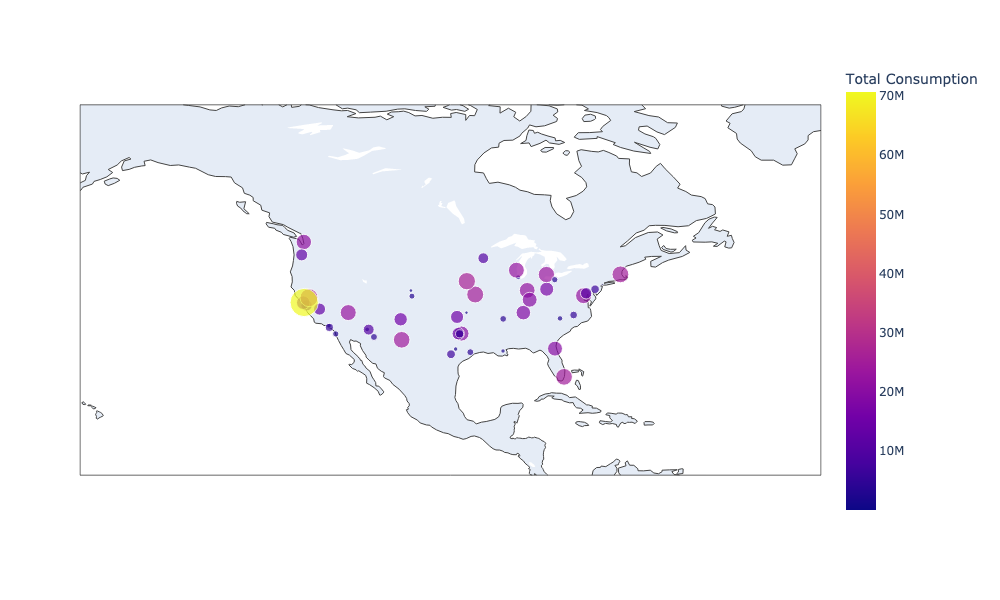

In [8]:
init_notebook_mode (connected = True)
fig = px.scatter_geo(df_asset, lat="Latitude",lon="Longitude",color="Total Consumption",hover_name="City", hover_data={'Renewable':True,'Non-Renewable':True}, size='Total Consumption')
fig.update_geos(
    center={"lat": 39.8283, "lon": -98.5795},  # Center of the USA
    projection_scale=3  # Zoom level (lower values zoom in more)
)
fig.update_layout(width=1000, 
    height=600 )
# fig.show()
fig.show("png")

### Accepeted input values

To check the accepted values for the individual fields of the request payload please visit the links below.

Market Based : https://developer.ibm.com/apis/catalog/envintelsuite--ibm-environmental-intelligence/GHG+Emissions+API#market


Location Based : https://developer.ibm.com/apis/catalog/envintelsuite--ibm-environmental-intelligence/GHG+Emissions+API#location


## Datacenter Carbon Footprints - Location Based API

Calculating Datacenter Carbon Footprints based on the location.

In [12]:
EI_location_API_ENDPOINT = f"{EI_BASE_URL}/v2/carbon/location"
CO2Response_list = []
for _,row in df_asset.iterrows():
    request_payload ={'customID'        : customer_id(customerid='Retailer_A_mobile_31234'), 
                    'onBehalfOfClient': customer_onBehalfOfClient(companyId='877889877',
                                                                    companyName='Retailer_A') , 
                    'organisation'    : customer_organisation(departmentId='384834',
                                                                departmentName='Acme_retail'), 
                    'requestType'     : customer_requestType(requestType='ACTUAL'), 
                    'location'        : customer_location(country=row['Country'],
                                                            stateProvince=row['State'],
                                                            zipPostCode=row['Zip Code'],
                                                            city=row['City']),
                    'site'            : customer_site(siteId='T2383823',
                                                        siteName='Retailed_A_South_Bank',
                                                        buildingId='B38383',
                                                        buildingName='Building_6'), 
                    'timePeriod'      : {'year' : pd.to_datetime(row['End Date (YYYY-MM-DD)']).year, 
                                            },
                    'activityData' : location_input(commodity=row['Commodity Usage'],
                                                        energyConsumedMWh=row['Total Consumption'])
                    }        

    CO2Response = Call_Carbon_API(EI_location_API_ENDPOINT , request_payload, mybearer_token)
    CO2Response_list.append(CO2Response)
df_location_res = pd.json_normalize(CO2Response_list)
df_asset ['loc_CO2e'] = df_location_res['CO2e (metric tonne)']

### Output Explanation

<b>CO2e (metric tonne)</b> -             Release of amounts of total greenhouse gases emitted (metric tonne)


### Datacenter - Location Based Carbon Footprints Distribution

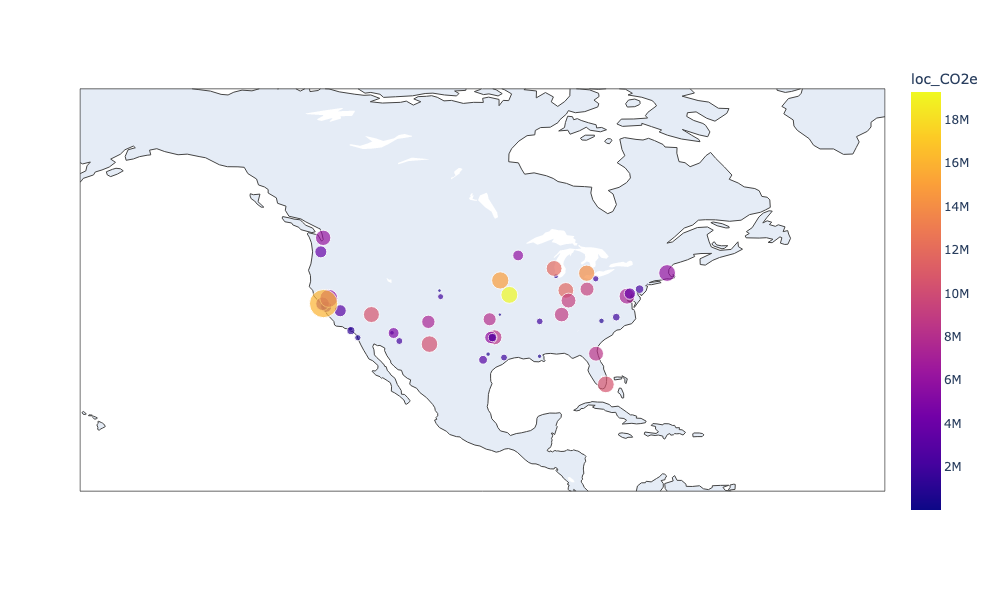

In [13]:
init_notebook_mode (connected = True)
fig = px.scatter_geo(df_asset, lat="Latitude",lon="Longitude",color="loc_CO2e",hover_name="City", hover_data={'Renewable':True,'Non-Renewable':True}, size='Total Consumption')
fig.update_geos(
    center={"lat": 39.8283, "lon": -98.5795},  # Center of the USA
    projection_scale=3  # Zoom level (lower values zoom in more)
)
fig.update_layout(width=1000, 
    height=600 )
# fig.show()
fig.show("png")

## Datacenter Carbon Footprints - Market Based API

Calculating Datacenter Carbon Footprints based on the market.

In [14]:
# function to convert date to "%m-%d-%Y" format if not 'nan'
def convert_date(date_string):
    if pd.notna(date_string):
        date_object = datetime.strptime(date_string, "%Y-%m-%d")
        return date_object.strftime("%m-%d-%Y")
    else:
        return date_string  # Return 'nan' or whatever value it is

# function to return 'na' if not 'nan' (not a valid value)
def check_nan(value):
    if pd.notna(value):
        return value
    else:
        return 'na'
    
EI_market_API_ENDPOINT = f"{EI_BASE_URL}/v2/carbon/market"
CO2Response_list = []
for _,row in df_asset.iterrows():
    request_payload ={'customID'        : customer_id(customerid='Retailer_A_mobile_31234'), 
                    'onBehalfOfClient': customer_onBehalfOfClient(companyId='877889877',
                                                                    companyName='Retailer_A') , 
                    'organisation'    : customer_organisation(departmentId='384834',
                                                                departmentName='Acme_retail'), 
                    'requestType'     : customer_requestType(requestType='ACTUAL'), 
                    'location'        : customer_location(country=row['Country'],
                                                            stateProvince=row['State'],
                                                            zipPostCode=row['Zip Code'],
                                                            city=row['City']),
                    'site'            : customer_site(siteId='T2383823',
                                                        siteName='Retailed_A_South_Bank',
                                                        buildingId='B38383',
                                                        buildingName='Building_6'), 
                    'timePeriod'      : {'year' : pd.to_datetime(row['End Date (YYYY-MM-DD)']).year, 
                                            },
                    'activityData'   :  market_input(commodity=row['Commodity Usage'],
                                                    energyConsumedMWh=row['Total Consumption'],
                                                    energySupplierResidualEF='na',
                                                    supplierNameREC='na',
                                                    energyPurchasedMWhREC='na',
                                                    emissionFactorREC='na',
                                                    sourceREC='na',
                                                    expiryDateREC='na',
                                                    instrumentTypeREC='na',
                                                    trackingSystemREC='na',
                                                    certificateNumberREC='na',
                                                    supplierNameREDI=check_nan(row['REDI Supplier Name']),
                                                    energyPurchasedMWhREDI=check_nan(row['Renewable']),
                                                    emissionFactorREDI='0',
                                                    sourceREDI=check_nan(row['REDI Energy Source']),
                                                    expiryDateREDI=convert_date(row['REDI Expiry Date']),
                                                    certificateNumberREDI=check_nan(row['REDI Certificate Number']),
                                                    supplierNameDEPC='na',
                                                    energyPurchasedMWhDEPC='na', 
                                                    suppliedEmissionFactorDEPC='na',
                                                    expiryDateDEPC='na',
                                                    certificateNumberDEPC='na')
                    }        

    CO2Response = Call_Carbon_API(EI_market_API_ENDPOINT , request_payload, mybearer_token)
    CO2Response_list.append(CO2Response)
df_market_res = pd.json_normalize(CO2Response_list)
df_asset ['market_CO2e'] = df_market_res['CO2e (metric tonne)']

### Datacenter - Market Based Carbon Footprints Distribution

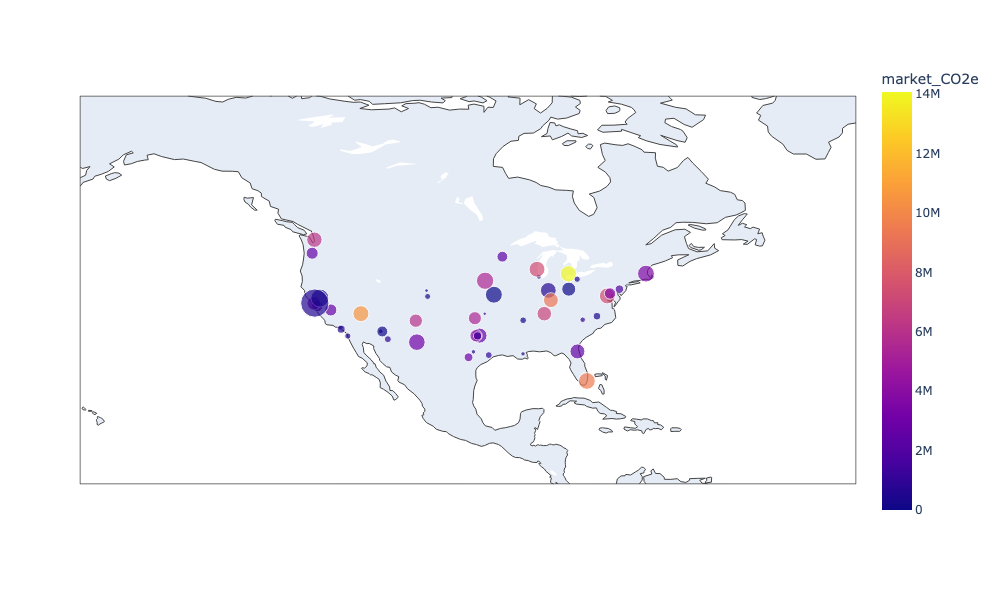

In [15]:
init_notebook_mode (connected = True)
fig = px.scatter_geo(df_asset, lat="Latitude",lon="Longitude",color="market_CO2e",hover_name="City", hover_data={'Renewable':True,'Non-Renewable':True}, size='Total Consumption')
fig.update_geos(
    center={"lat": 39.8283, "lon": -98.5795},  # Center of the USA
    projection_scale=3  # Zoom level (lower values zoom in more),
)
fig.update_layout(width=1000, 
    height=600 )
# fig.show()
fig.show("png")

## Output Explanation



<b>CO2e (metric tonne)</b> -             Release of amounts of total greenhouse gases emitted (metric tonne)


## Comparison of Location and Market Carbon Intensity

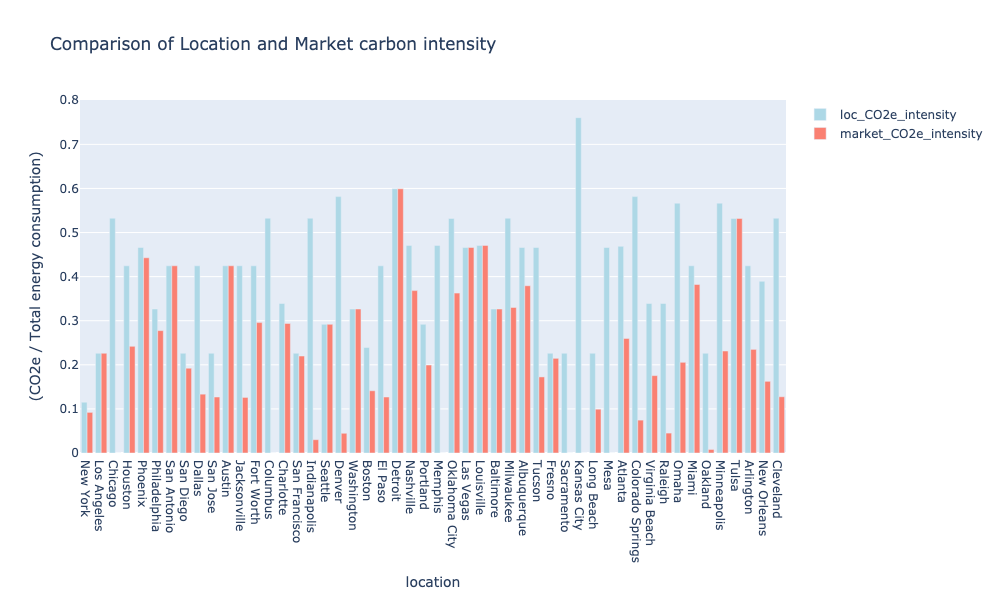

In [16]:
fig = go.Figure()
fig.add_trace(go.Bar(x=df_asset['City'], y=df_asset['loc_CO2e']/df_asset['Total Consumption'], name='loc_CO2e_intensity', marker_color='lightblue'))
fig.add_trace(go.Bar(x=df_asset['City'], y=df_asset['market_CO2e']/df_asset['Total Consumption'], name='market_CO2e_intensity', marker_color='salmon'))
fig.update_layout(
    title='Comparison of Location and Market carbon intensity ',
    xaxis_title='location',
    yaxis_title='(CO2e / Total energy consumption)',
    barmode='group',
    width=1000, 
    height=600 
)
fig.show("png")

Here, we see the carbon emission intensity of location and market based method across 50 sample datacenters. The location based emission considers only the average grid emission factor, whereas the market based method considers the purchase of renewables as well as per GHG protocol. The variation in market based carbon intensity in comparison to location based across different locations shows the additional effort made by the enterprises to reduce the carbon footprints through the purchase of renewables. The organisation can make decision to reduce further their carbon footprints based on the market based carbon intensity.